Generate plots based on parametric dataset (compare 4 methods - two full signal and two trial-based)

In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import joypy

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'results\\synthetic\\dataset\\fig2_3_4a\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'

fig_folder = project_folder_path + 'results\\synthetic\\fig_drafts_paper\\'

In [3]:
save_fig = False

### Load data

In [4]:
with open(dataset_folder + '1_spike_trains_3params_var_len600sec_100000.pkl','rb') as f:
    data = pickle.load(f)

spike_trains = data['spike_trains']
alphas = data['alphas']
fr_values = data['fr_values']
taus_ms = data['tau_ms']
duration_ms = data['duration_ms']

print(f'n spike trains {len(spike_trains)}, len {spike_trains[0][-1]/1000}, duration_ms {duration_ms}')

n spike trains 100000, len 598.8243581617338, duration_ms 600000


In [5]:
with open(results_folder + 'acf_isttc_full_50ms_20lags_dict.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

with open(results_folder + 'acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

with open(results_folder + 'pearsonr_trial_avg_50ms_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_concat_50ms_dict.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

print(f'len isttc_full_dict {len(isttc_full_dict)}')
print(f'len acf_full_dict {len(acf_full_dict)}')
print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')

len isttc_full_dict 100000
len acf_full_dict 100000
len pearsonr_trial_avg_dict 100000
len sttc_trial_concat_dict 100000


### Make summary dfs

In [6]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [7]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [8]:
def get_trials_plot_df(trial_dict_, method_, n_iteration_=None):
    records = []
    for unit_id, data in trial_dict_.items():
        taus = data['taus']
        acfs = data['acf']

        if n_iteration_ is not None:
            # only one trial per unit
            idx = n_iteration_[unit_id]
            taus_to_iter = [(taus[idx], acfs[idx])]
        else:
            # all trials for this unit
            taus_to_iter = zip(taus, acfs)

        for tau_dict, acf_array in taus_to_iter:
            records.append({
                'unit_id': unit_id,
                'tau': tau_dict['tau'],
                'fit_r_squared': tau_dict['fit_r_squared'],
                'decline_150_250': calculate_acf_decline_flag(acf_array, start_idx=2, end_idx=4),
                'method': method_,
            })

    df = pd.DataFrame.from_records(records)
    df['tau_ms'] = df['tau'] * 50

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}')

    return df

In [9]:
data = []
for unit_id, unit_data in acf_full_dict.items():
    taus = unit_data['taus']  
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'tau_lower': taus['tau_lower'],
        'tau_upper': taus['tau_upper'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
acf_full_plot_df = pd.DataFrame(data)
acf_full_plot_df['tau_ms'] = acf_full_plot_df['tau'] * 50

rows_with_nans_df = acf_full_plot_df[acf_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')
acf_full_plot_df['method'] = 'acf_full'
acf_full_plot_df['fr'] = fr_values
acf_full_plot_df['alpha'] = alphas
acf_full_plot_df['tau_ms_true'] = taus_ms
acf_full_plot_df['tau_diff_abs'] = np.abs(acf_full_plot_df['tau_ms'] - acf_full_plot_df['tau_ms_true'])
acf_full_plot_df['tau_diff_rel'] = acf_full_plot_df['tau_diff_abs'] / acf_full_plot_df['tau_ms_true'] * 100

acf_full_plot_df.head(2)

N rows with NaNs 11


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,tau_ms,method,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel
0,0,2.217899,2.119224,2.316575,0.998369,True,110.894975,acf_full,7.741821,0.851099,150.923515,40.028540,26.522401
1,1,2.568210,2.437150,2.699270,0.997899,True,128.410512,acf_full,4.394396,0.858098,147.947233,19.536721,13.205195


In [10]:
data = []
for unit_id, unit_data in isttc_full_dict.items():
    taus = unit_data['taus']      
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'tau_lower': taus['tau_lower'],
        'tau_upper': taus['tau_upper'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
isttc_full_plot_df = pd.DataFrame(data)
isttc_full_plot_df['method'] = 'isttc_full'
isttc_full_plot_df['tau_ms'] = isttc_full_plot_df['tau'] * 50

rows_with_nans_df = isttc_full_plot_df[isttc_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')

isttc_full_plot_df['method'] = 'isttc_full'
isttc_full_plot_df['fr'] = fr_values
isttc_full_plot_df['alpha'] = alphas
isttc_full_plot_df['tau_ms_true'] = taus_ms
isttc_full_plot_df['tau_diff_abs'] = np.abs(isttc_full_plot_df['tau_ms'] - isttc_full_plot_df['tau_ms_true'])
isttc_full_plot_df['tau_diff_rel'] = isttc_full_plot_df['tau_diff_abs'] / isttc_full_plot_df['tau_ms_true'] * 100

isttc_full_plot_df.head(2)

N rows with NaNs 0


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel
0,0,2.523412,2.362379,2.684445,0.996707,True,isttc_full,126.170618,7.741821,0.851099,150.923515,24.752897,16.400954
1,1,2.834326,2.688470,2.980182,0.997916,True,isttc_full,141.716309,4.394396,0.858098,147.947233,6.230924,4.211585


In [11]:
# for trial based measures one realization of trials is taken
random_trials_impl = np.zeros(len(sttc_trial_concat_dict)).astype(int)

pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg', random_trials_impl)
sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat', random_trials_impl)

pearsontr_trial_avg_plot_df['fr'] = fr_values
pearsontr_trial_avg_plot_df['alpha'] = alphas
pearsontr_trial_avg_plot_df['tau_ms_true'] = taus_ms
pearsontr_trial_avg_plot_df['tau_diff_abs'] = np.abs(pearsontr_trial_avg_plot_df['tau_ms'] - pearsontr_trial_avg_plot_df['tau_ms_true'])
pearsontr_trial_avg_plot_df['tau_diff_rel'] = pearsontr_trial_avg_plot_df['tau_diff_abs'] / pearsontr_trial_avg_plot_df['tau_ms_true'] * 100

sttc_trial_concat_plot_df['fr'] = fr_values
sttc_trial_concat_plot_df['alpha'] = alphas
sttc_trial_concat_plot_df['tau_ms_true'] = taus_ms
sttc_trial_concat_plot_df['tau_diff_abs'] = np.abs(sttc_trial_concat_plot_df['tau_ms'] - sttc_trial_concat_plot_df['tau_ms_true'])
sttc_trial_concat_plot_df['tau_diff_rel'] = sttc_trial_concat_plot_df['tau_diff_abs'] / sttc_trial_concat_plot_df['tau_ms_true'] * 100

N rows with NaNs 12393


In [12]:
tau_plot_all_long_df = pd.concat([acf_full_plot_df, isttc_full_plot_df, 
                              pearsontr_trial_avg_plot_df, 
                              sttc_trial_concat_plot_df])
tau_plot_all_long_df['log_tau_ms'] = np.log10(tau_plot_all_long_df['tau_ms'])
tau_plot_all_long_df['ci_size'] = tau_plot_all_long_df['tau_upper'] - tau_plot_all_long_df['tau_lower']
tau_plot_all_long_df.reset_index(inplace=True, drop=True)

print(f'len tau_plot_long_df {len(tau_plot_all_long_df)}')

tau_plot_all_long_df.head(3)

len tau_plot_long_df 400000


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,tau_ms,method,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,log_tau_ms,ci_size
0,0,2.217899,2.119224,2.316575,0.998369,True,110.894975,acf_full,7.741821,0.851099,150.923515,40.028540,26.522401,2.044912,0.197350
1,1,2.568210,2.437150,2.699270,0.997899,True,128.410512,acf_full,4.394396,0.858098,147.947233,19.536721,13.205195,2.108601,0.262120
2,2,5.227451,4.334421,6.120482,0.984960,True,261.372568,acf_full,8.587393,0.528805,267.002290,5.629722,2.108492,2.417260,1.786061


In [13]:
tau_plot_all_long_df_subset_1 = tau_plot_all_long_df[['unit_id', 'method', 'fit_r_squared', 'tau', 'decline_150_250']].copy()
tau_plot_all_long_df_subset_1

,unit_id,method,fit_r_squared,tau,decline_150_250
0,0,acf_full,9.983688e-01,2.217899,True
1,1,acf_full,9.978989e-01,2.568210,True
2,2,acf_full,9.849601e-01,5.227451,True
3,3,acf_full,8.897188e-01,3.950209,True
4,4,acf_full,9.957372e-01,3.717963,True
...,...,...,...,...,...
399995,99995,sttc_trial_concat,1.668135e-01,0.672735,True
399996,99996,sttc_trial_concat,8.239274e-01,1.623215,True
399997,99997,sttc_trial_concat,4.651321e-02,1.574226,True
399998,99998,sttc_trial_concat,5.247993e-01,0.078543,False


In [30]:
nans_neg_r2_per_method_df = tau_plot_all_long_df_subset_1.groupby('method').agg(
    tau_nans=('tau', lambda x: x.isna().sum()),
    fit_r_squared_neg=('fit_r_squared', lambda x: (x < 0).sum()),
    excluded=('unit_id', lambda idx: ((tau_plot_all_long_df_subset_1.loc[idx.index, 'tau'].isna()) | 
                                          (tau_plot_all_long_df_subset_1.loc[idx.index, 'fit_r_squared'] < 0)).sum())
).reset_index()
nans_neg_r2_per_method_df

,method,tau_nans,fit_r_squared_neg,excluded
0,acf_full,11,237,248
1,isttc_full,0,238,238
2,pearsonr_trial_avg,12393,4201,16594
3,sttc_trial_concat,0,6268,6268


In [14]:
def compute_exclusion(group):
    tau_nans = group['tau'].isna().sum()
    fit_r_squared_neg = (group['fit_r_squared'] < 0).sum()
    either_issue = ((group['tau'].isna()) | (group['fit_r_squared'] < 0)).sum()
    total = len(group)
    percent_either_issue = 100 * either_issue / total if total > 0 else 0
    return pd.Series({
        'tau_nans': tau_nans,
        'fit_r_squared_neg': fit_r_squared_neg,
        'exclusion': either_issue,
        'exclusion_perc': percent_either_issue
    })

exclusion_df = tau_plot_all_long_df_subset_1.groupby('method').apply(compute_exclusion).reset_index()
exclusion_df

C:\Users\ipochino\AppData\Local\Temp\ipykernel_9152\2663997986.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exclusion_df = tau_plot_all_long_df_subset_1.groupby('method').apply(compute_exclusion).reset_index()


,method,tau_nans,fit_r_squared_neg,exclusion,exclusion_perc
0,acf_full,11.0,237.0,248.0,0.248
1,isttc_full,0.0,238.0,238.0,0.238
2,pearsonr_trial_avg,12393.0,4201.0,16594.0,16.594
3,sttc_trial_concat,0.0,6268.0,6268.0,6.268


In [15]:
included_df = tau_plot_all_long_df_subset_1.query('tau.notna() and fit_r_squared >= 0').copy()
included_df.groupby(by='method', as_index=False).count()

,method,unit_id,fit_r_squared,tau,decline_150_250
0,acf_full,99752,99752,99752,99752
1,isttc_full,99762,99762,99762,99762
2,pearsonr_trial_avg,83406,83406,83406,83406
3,sttc_trial_concat,93732,93732,93732,93732


In [16]:
acf_decline_df = included_df.groupby('method').agg(
    num_true=('decline_150_250', lambda x: x.sum()),
    total=('decline_150_250', 'count')
).assign(
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
acf_decline_df

,method,num_true,total,percent_true
0,acf_full,92843,99752,93.073823
1,isttc_full,93114,99762,93.336140
2,pearsonr_trial_avg,64850,83406,77.752200
3,sttc_trial_concat,73587,93732,78.507874


### Plots

In [17]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2'
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_concat = '#955da2' 

colors = [color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_concat]

In [ ]:
tau_plot_all_long_df.groupby(by='method', as_index=False)['fit_r_squared'].describe()

In [ ]:
tau_plot_all_long_df.groupby(by='method', as_index=False)['decline_150_250'].describe()

##### Percentage on NaNs in tau and negative R-squared

C:\Users\ipochino\AppData\Local\Temp\ipykernel_9152\775456508.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='method', y='exclusion_perc', data=exclusion_df, palette=['steelblue'])
C:\Users\ipochino\AppData\Local\Temp\ipykernel_9152\775456508.py:3: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(ax=axes[0], x='method', y='exclusion_perc', data=exclusion_df, palette=['steelblue'])
C:\Users\ipochino\AppData\Local\Temp\ipykernel_9152\775456508.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


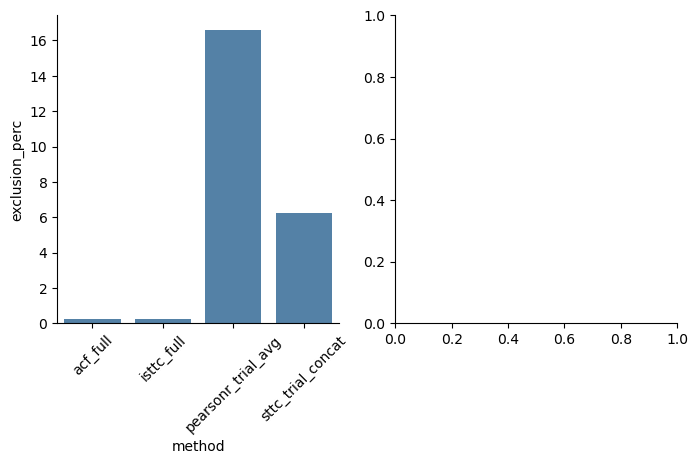

In [19]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

sns.barplot(ax=axes[0], x='method', y='exclusion_perc', data=exclusion_df, palette=['steelblue'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# sns.histplot(ax=axes[1], x=included_df['pearson'].values, y=tau_df_pivot_ac_metric['sttc'].values, bins=250)
# axes[0].plot([0, 1], [0, 1], c='k', transform=axes[0].transAxes)
# axes[0].set_aspect('equal', adjustable='box')
# axes[0].set_xlabel('Pearson R-squared')
# axes[0].set_ylabel('STTC R-squared')

sns.despine()

##### R-squared